# Code for Decision tree. 

### Code includes Individual Tree node class, Decision Tree Classifier.

The classifier contains functions to calculate entropy, information gain ratio, best split for the given data.

It even contains functions to predict for test data, visualize tthe tree and save it as a png.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter

import graphviz

class TreeNode:
    def __init__(self):
        self.feature_index = None  # Index of the feature to split on
        self.threshold = None      # Threshold value for the split
        self.left = None           # Left subtree
        self.right = None          # Right subtree
        self.is_leaf = False       # Is this node a leaf node?
        self.predicted_class = None  # Predicted class label if this is a leaf node
        self.entropy = None        # Entropy of this node
        self.gain_ratio = None     # Gain ratio of this split

class DecisionTreeClassifier:
    def __init__(self):
        self.root = None

    def fit(self, X, y):
        self.root = self._build_tree(X, y)

    def _build_tree(self, X, y):
        node = TreeNode()

        # Check if stopping criteria are met
        if len(y) == 0:
            node.is_leaf = True
            node.predicted_class = 1  # Predict class 1 when no majority class
            return node

        if len(set(y)) == 1:
            node.is_leaf = True
            node.predicted_class = y[0]
            return node

        # Find the best split
        num_samples, num_features = X.shape
        best_split = None
        best_gain_ratio = -1

        for feature_index in range(num_features):
            values = X[:, feature_index]
            unique_values = np.unique(values)

            for threshold in unique_values:
                left_indices = X[:, feature_index] >= threshold
                right_indices = ~left_indices
                left_entropy = self._calculate_entropy(y[left_indices])
                right_entropy = self._calculate_entropy(y[right_indices])
                split_entropy = (len(y[left_indices]) / num_samples) * left_entropy + \
                                (len(y[right_indices]) / num_samples) * right_entropy
                gain = self._calculate_entropy(y) - split_entropy
                split_info = -1 * (len(y[left_indices] ) / num_samples) * np.log2((len(y[left_indices])+ 1e-10) / num_samples) - \
                             ((len(y[right_indices])+ 1e-10) / num_samples) * np.log2((len(y[right_indices]) + 1e-10) / num_samples)

                # Avoid division by zero
                gain_ratio = gain / (split_info + 1e-10)

                if gain_ratio > best_gain_ratio:
                    best_gain_ratio = gain_ratio
                    best_split = (feature_index, threshold)

        if best_gain_ratio == 0:
            node.is_leaf = True
            node.predicted_class = 1  # Predict class 1 when no gain
            return node

        # Split the data and continue building the tree
        node.feature_index, node.threshold = best_split
        left_indices = X[:, node.feature_index] >= node.threshold
        right_indices = ~left_indices
        node.left = self._build_tree(X[left_indices], y[left_indices])
        node.right = self._build_tree(X[right_indices], y[right_indices])
        node.gain_ratio = best_gain_ratio
        node.entropy = self._calculate_entropy(y)

        return node

    def _calculate_entropy(self, y):
        if len(y) == 0:
            return 0
        counts = Counter(y)
        entropy = 0
        for count in counts.values():
            p = count / len(y)
            entropy -= p * np.log2(p)
        return entropy

    def predict(self, X):
        return [self._predict_tree(self.root, x) for x in X]

    def _predict_tree(self, node, x):
        if node.is_leaf:
            return node.predicted_class
        if x[node.feature_index] > node.threshold:
            return self._predict_tree(node.left, x)
        else:
            return self._predict_tree(node.right, x)
    
    def visualize_tree(self, plot_name, feature_names=None, class_names=None):
        dot = graphviz.Digraph(format='png')
        self._add_nodes(dot, self.root, feature_names, class_names)
        dot.render(plot_name)  # Generates decision_tree.png

    def _add_nodes(self, dot, node, feature_names, class_names):
        if node is not None:
            if node.is_leaf:
                if class_names is not None:
                    label = f"Class: {class_names.get(node.predicted_class, node.predicted_class)}"
                else:
                    label = f"Class: {node.predicted_class}"
            else:
                if feature_names is not None:
                    label = f"X{feature_names[node.feature_index]} >= {node.threshold:.2f}" # \nEntropy: {node.entropy:.2f}\nGain Ratio: {node.gain_ratio:.2f}"
                else:
                    label = f"X{node.feature_index} >= {node.threshold:.2f}" # \nEntropy: {node.entropy:.2f}\nGain Ratio: {node.gain_ratio:.2f}"

            dot.node(str(id(node)), label=label)

            if node.left is not None:
                dot.edge(str(id(node)), str(id(node.left)), label="True")
                self._add_nodes(dot, node.left, feature_names, class_names)

            if node.right is not None:
                dot.edge(str(id(node)), str(id(node.right)), label="False")
                self._add_nodes(dot, node.right, feature_names, class_names)

    def count_nodes(self):
        return self._count_nodes_recursive(self.root)

    def _count_nodes_recursive(self, node):
        if isinstance(node, TreeNode):  # Internal node
            _, left_subtree, right_subtree = node.threshold, node.left, node.right
            return 1 + self._count_nodes_recursive(left_subtree) + self._count_nodes_recursive(right_subtree)
        else:  # Leaf node
            return 1
    


## Define functions to plot Scatter plots and the decision boundaries for the data points

In [3]:
def scatter_plot_data(X, y):
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0', marker='o', c='blue', s=50)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1', marker='x', c='red', s=50)
    plt.xlabel('X1')
    plt.ylabel('X2')
    plt.legend(loc='best')
    plt.title('Scatter Plot of Dataset')
    plt.grid(True)
    plt.show()

def plot_decision_boundary(X, y, classifier):
    # Create a mesh to plot the decision boundary
    h = 0.02  # Step size in the mesh
    x_min, x_max = X[:, 0].min() - 0.1, X[:, 0].max() + 0.1
    y_min, y_max = X[:, 1].min() - 0.1, X[:, 1].max() + 0.1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h), np.arange(y_min, y_max, h))

    # Predict the class labels for the mesh grid
    Z = classifier.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = np.array(Z).reshape(xx.shape)

    # Create a scatter plot of the data
    plt.figure(figsize=(8, 6))
    plt.scatter(X[y == 0, 0], X[y == 0, 1], label='Class 0', marker='o', c='blue', s=20)
    plt.scatter(X[y == 1, 0], X[y == 1, 1], label='Class 1', marker='x', c='red', s=20)
    plt.xlabel('X1')
    plt.ylabel('X2')
    
    # Overlay the decision boundary
    plt.contourf(xx, yy, Z, cmap=plt.cm.RdBu, alpha=0.5)
    plt.xlim(xx.min(), xx.max())
    plt.ylim(yy.min(), yy.max())
    
    plt.legend(loc='best')
    plt.title('Decision Boundary and Scatter Plot')
    plt.grid(True)
    plt.show()


### Plot the decision tree, scatter plot and decision boundary for a given dataset

Note to self:  *'Dbig.txt' takes about 6-6.5 min to run. So do not run it again and again to check if the classifier is working. Test it with 'D1.txt' or 'D2.txt'*

Number of nodes = 7


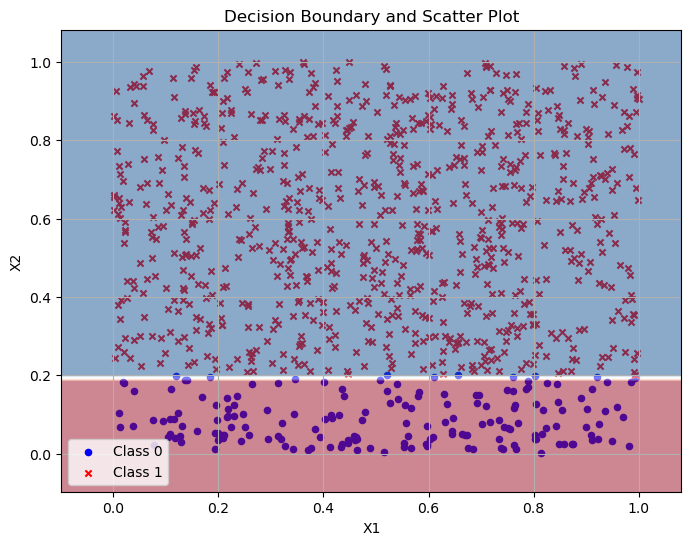

In [3]:
data = pd.read_csv("./data/D1.txt", sep=" ", header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize and fit the decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Visualize the decision tree
clf.visualize_tree('D1')
print("Number of nodes = " + str(clf.count_nodes()))

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf)

### Question 2

#### Question 2.1

 Hypothesis H1: Stop the splits when all training items are of same class.
Hypothesis H2: Determine some thresholds, $T_n = t_1, t_2, ... t_n$ such that further split is forced with $m_1, m_2, .... m_n$ elements in each split group.

Entropy is given by, $H(S) = - \sum_{i=1}^{c} p_i * log_2(p_i)$

For H1, entropy is given by,
$H_1(S) = - 0 * log_2(0) - 1 log_2(1) = 0$

Similary, for H2, Entropy of each split is 0.
Thus, $H_2(S) = 0$.

Information gain is $H_1(S) - H_2(S) = 0$.

Thus, there is no additional gains from splitting further if all samples in a node belong to the same class. Since both give the same result, the simplest solution is usually the best solution i.e, No further splits for that node. 

#### Question 2.2

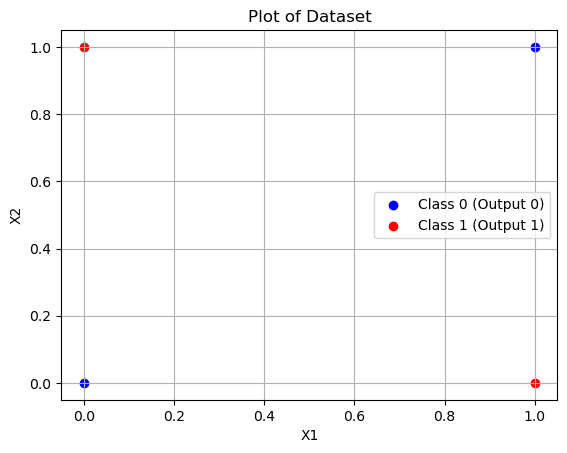

In [4]:
import matplotlib.pyplot as plt

# Define the XOR data points
X = [[0, 0], [0, 1], [1, 0], [1, 1]]
y = [0, 1, 1, 0]

# Separate the data points into two classes
class_0 = [X[i] for i in range(4) if y[i] == 0]
class_1 = [X[i] for i in range(4) if y[i] == 1]

# Plot the XOR dataset
plt.scatter([point[0] for point in class_0], [point[1] for point in class_0], c='blue', label='Class 0 (Output 0)')
plt.scatter([point[0] for point in class_1], [point[1] for point in class_1], c='red', label='Class 1 (Output 1)')
plt.xlabel('X1')
plt.ylabel('X2')
plt.legend(loc='best')
plt.title('Plot of Dataset')
plt.grid(True)
plt.show()


#### Question 2.3

In [5]:
def calculate_information_gain(data):
    # Extract features and labels from the data
    X = data[:, :-1]
    y = data[:, -1]

    # Calculate entropy of the entire dataset
    total_entropy = calculate_entropy(y)

    num_samples, num_features = X.shape
    best_gain_ratio = 0
    best_split = None
    information_gain = []
    information_gain_ratio = []
    # Iterate through all possible splits
    for feature_index in range(num_features):
        values = X[:, feature_index]
        unique_values = np.unique(values)

        for threshold in unique_values:
            left_indices = values >= threshold
            right_indices = ~left_indices

            left_entropy = calculate_entropy(y[left_indices])
            right_entropy = calculate_entropy(y[right_indices])

            # Calculate information gain
            split_entropy = (len(y[left_indices]) / num_samples) * left_entropy + \
                            (len(y[right_indices]) / num_samples) * right_entropy
            gain = total_entropy - split_entropy

            information_gain.append(gain)

            # Calculate split information
            split_info = -1 * (len(y[left_indices]) / num_samples) * np.log2((len(y[left_indices]) + 1e-10) / num_samples) - \
                         (len(y[right_indices]) / num_samples) * np.log2((len(y[right_indices]) + 1e-10) / num_samples)

            # Avoid division by zero
            gain_ratio = gain / (split_info + 1e-10)

            information_gain_ratio.append(gain_ratio)

            # Store the best split based on gain ratio
            if gain_ratio > best_gain_ratio:
                best_gain_ratio = gain_ratio
                best_split = (feature_index, threshold, gain, gain_ratio)

    return information_gain, information_gain_ratio, best_split

def calculate_entropy(y):
    if len(y) == 0:
        return 0
    counts = Counter(y)
    entropy = 0
    num_samples = len(y)
    for count in counts.values():
        p = count / num_samples
        entropy -= p * np.log2(p)
    return entropy


data = np.loadtxt("./data/Druns.txt")

# Calculate the best split for the root node
inf_gain, inf_gain_ratio, best_split = calculate_information_gain(data)
print("Best Split (Feature Index, Threshold, Information Gain, Information Gain Ratio):", best_split)
print(inf_gain)
print(inf_gain_ratio)

Best Split (Feature Index, Threshold, Information Gain, Information Gain Ratio): (1, 8.0, 0.18905266854301617, 0.4301569160587793)
[0.0, 0.04417739186726133, 0.0, 0.04417739186726133, 0.03827452220629246, 0.004886164091842726, 0.0010821659130775263, 0.016313165825732057, 0.04945207278939401, 0.10519553207004628, 0.19958702318968735, 0.03827452220629246, 0.18905266854301617]
[0.0, 0.10051807674334641, 0.0, 0.10051807674334641, 0.055953759625229256, 0.005780042204647926, 0.0011443495171874808, 0.01641113684088423, 0.04974906417808657, 0.11124029585472035, 0.23609960612300485, 0.055953759625229256, 0.4301569160587793]


In [6]:
def calculate_information_gain_and_mutual_information(data):
    # Extract features and labels from the data
    X = data[:, :-1]
    y = data[:, -1]

    # Calculate entropy of the entire dataset
    total_entropy = calculate_entropy(y)

    num_samples, num_features = X.shape
    best_info_gain = 0
    best_split = None

    information_gain = []
    mutual_information = []

    # Iterate through all possible splits
    for feature_index in range(num_features):
        values = X[:, feature_index]
        unique_values = np.unique(values)

        for threshold in unique_values:
            left_indices = values >= threshold
            right_indices = ~left_indices

            left_entropy = calculate_entropy(y[left_indices])
            right_entropy = calculate_entropy(y[right_indices])

            # Calculate information gain
            split_entropy = (len(y[left_indices]) / num_samples) * left_entropy + \
                            (len(y[right_indices]) / num_samples) * right_entropy
            info_gain = total_entropy - split_entropy
            
            
            information_gain.append(info_gain)
            
            # Calculate mutual information when entropy is zero
            if left_entropy == 0 or right_entropy == 0:
                mutual_info = info_gain
            else:
                mutual_info = info_gain / min(left_entropy, right_entropy)

            mutual_information.append(mutual_info)

            # Store the best split based on information gain or mutual information
            if info_gain > best_info_gain:
                best_info_gain = info_gain
                best_split = (feature_index, threshold, info_gain, mutual_info)

    return information_gain, mutual_information, best_split

def calculate_entropy(y):
    if len(y) == 0:
        return 0
    counts = Counter(y)
    entropy = 0
    num_samples = len(y)
    for count in counts.values():
        p = count / num_samples
        entropy -= p * np.log2(p)
    return entropy

data = np.loadtxt("./data/Druns.txt")


# Calculate the best split for the root node (information gain or mutual information)
inf_gain, mut_inf, best_split = calculate_information_gain_and_mutual_information(data)
print("Best Split (Feature Index, Threshold, Information Gain, Mutual Information):", best_split)
print(inf_gain)
print("\n", mut_inf)

Best Split (Feature Index, Threshold, Information Gain, Mutual Information): (1, 6.0, 0.19958702318968735, 0.367181896620856)
[0.0, 0.04417739186726133, 0.0, 0.04417739186726133, 0.03827452220629246, 0.004886164091842726, 0.0010821659130775263, 0.016313165825732057, 0.04945207278939401, 0.10519553207004628, 0.19958702318968735, 0.03827452220629246, 0.18905266854301617]

 [0.0, 0.04417739186726133, 0.0, 0.04417739186726133, 0.05008413569969012, 0.006022797786024688, 0.0013339024934254087, 0.022596662938124457, 0.07607748770264165, 0.17779342886468286, 0.367181896620856, 0.05008413569969012, 0.18905266854301617]


#### Question 2.4

In [7]:
data = pd.read_csv("./data/D3leaves.txt", sep=" ", header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize and fit the decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Visualize the decision tree
clf.visualize_tree('D3leaves')

# scatter_plot_data(X,y)
# plot_decision_boundary(X, y, clf)

#### Question 2.5

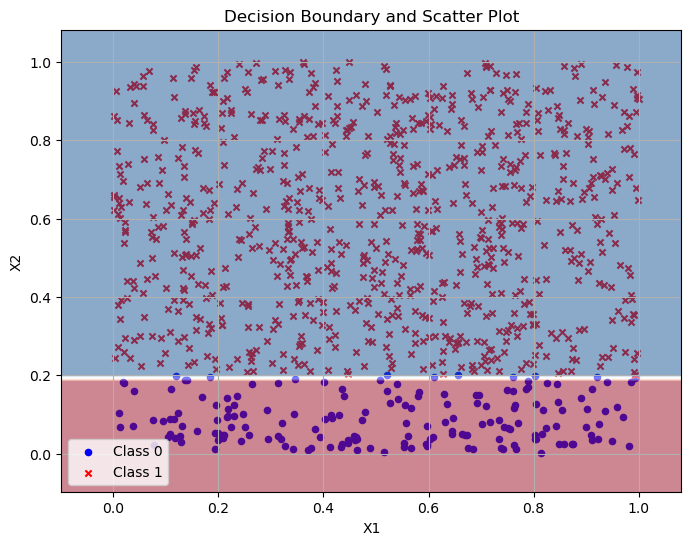

In [8]:
data = pd.read_csv("./data/D1.txt", sep=" ", header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize and fit the decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Visualize the decision tree
clf.visualize_tree('D1')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf)

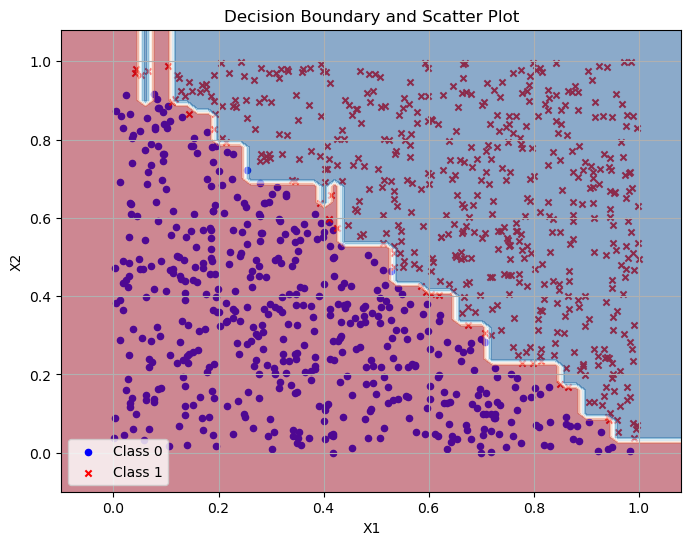

In [9]:
data = pd.read_csv("./data/D2.txt", sep=" ", header=None)
X = data.iloc[:, :-1].values
y = data.iloc[:, -1].values

# Initialize and fit the decision tree
clf = DecisionTreeClassifier()
clf.fit(X, y)

# Visualize the decision tree
clf.visualize_tree('D2')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf)

#### Question 2.6

As depicted in Q2.5 and Fig. 3 and Fig. 5, for ”D1.txt”, the decision boundary is pretty simple to interpret due to it being a horizontal line. It can be seen that the decision boundary performs very good as well. We
can see that most of the data points of Class 1 is above the decision boundary (i.e, Class 1 : X2 >= 0.20).
For the ”D2.txt” dataset, it can be seen that Class 0 points tend to occupy the lower diagonal half of the
space and Class 1 occupies upper diagonal half of the space. It can be noted that the decision boundary is
seemingly moving along a straight line with negative slope. The jagged boundary of the decision tree might
be due to it’s ability to create a boundary that is horizontal or vertical (Due to thresholding decision). The
boundary might be finer if there were a significantly larger samples in the space

#### Question 2.7


(process:8124): GLib-GIO-WARNING **: 20:56:54.389: Unexpectedly, UWP app `Microsoft.ScreenSketch_11.2306.44.0_x64__8wekyb3d8bbwe' (AUMId `Microsoft.ScreenSketch_8wekyb3d8bbwe!App') supports 29 extensions but has no verbs


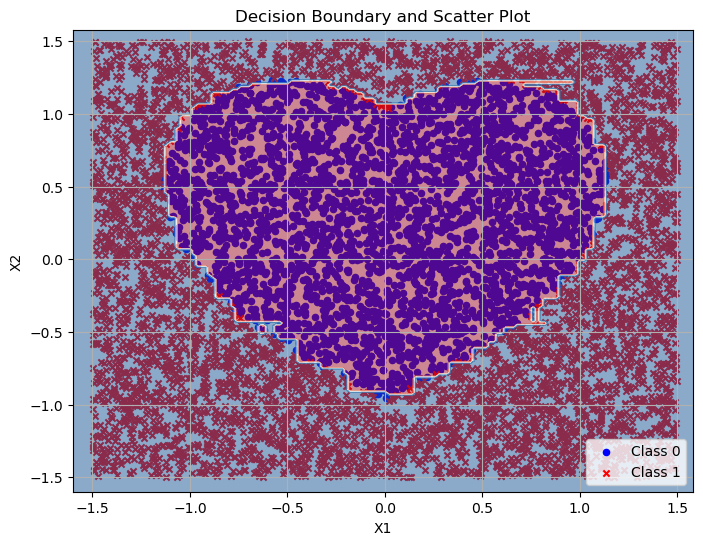

In [10]:
import random
data = np.loadtxt("./data/Dbig.txt")

train_size = 8192

indices = list(range(len(data)))
random.shuffle(indices)
random.shuffle(indices)

train_idx = indices[:train_size]
test_idx = indices[train_size:]

train_set = np.asarray([data[i] for i in train_idx])
test_set = np.asarray([data[i] for i in test_idx])


X = train_set[:,:-1]
y = train_set[:, -1]

# Initialize and fit the decision tree
clf8192 = DecisionTreeClassifier()
clf8192.fit(X, y)

# Visualize the decision tree
clf8192.visualize_tree('D8192')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf8192)

Create subsets for training data

In [11]:
D2048 = train_set[:2048]
D512 = D2048[:512]
D128 = D512[:128]
D32 = D128[:32] 

#### Fit trees for each subset and plot for each dataset

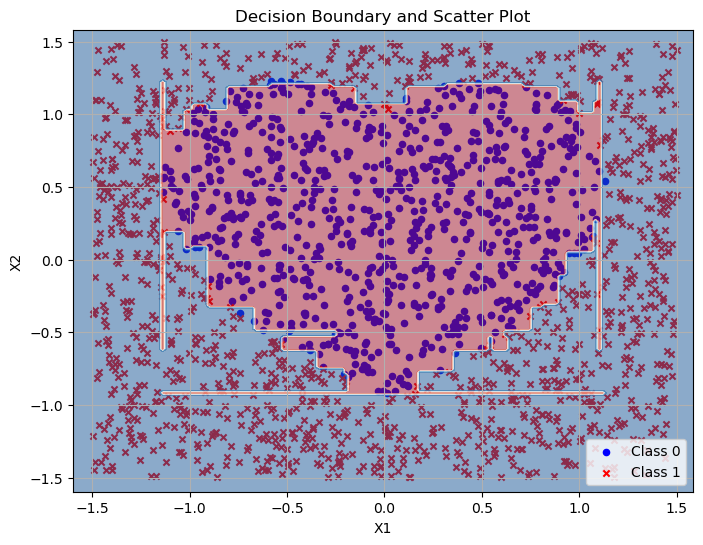

In [12]:
X = D2048[:,:-1]
y = D2048[:, -1]

clf2048 = DecisionTreeClassifier()
clf2048.fit(X, y)
clf2048.visualize_tree('D2048')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf2048)

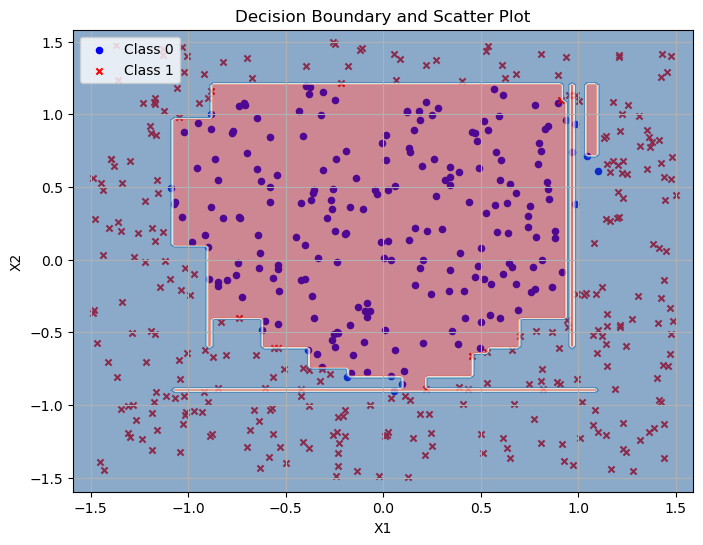

In [13]:
X = D512[:,:-1]
y = D512[:, -1]

clf512 = DecisionTreeClassifier()
clf512.fit(X, y)
clf512.visualize_tree('D512')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf512)

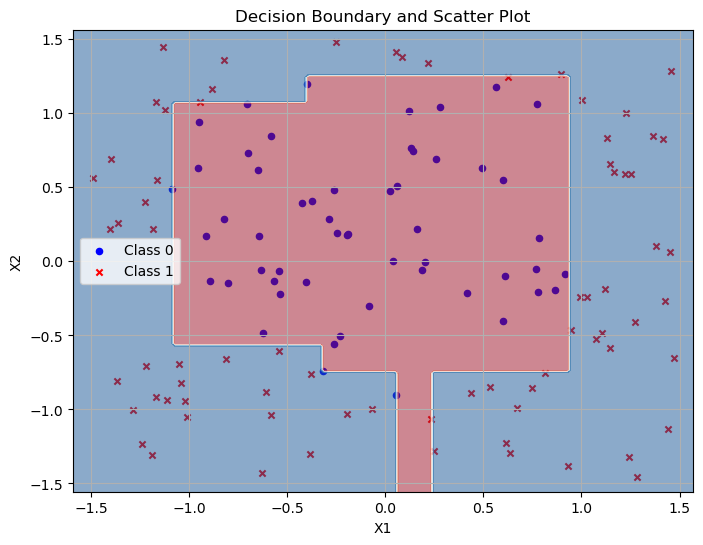

In [14]:
X = D128[:,:-1]
y = D128[:, -1]

clf128 = DecisionTreeClassifier()
clf128.fit(X, y)
clf128.visualize_tree('D128')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf128)

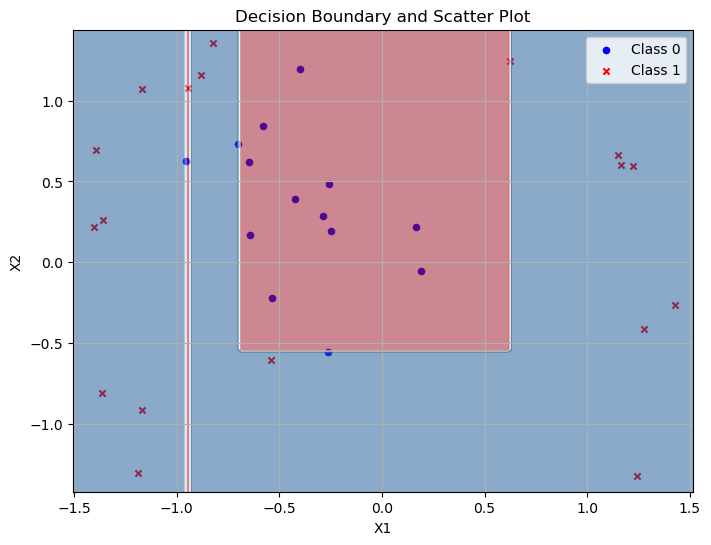

In [15]:
X = D32[:,:-1]
y = D32[:, -1]

clf32 = DecisionTreeClassifier()
clf32.fit(X, y)
clf32.visualize_tree('D32')

# scatter_plot_data(X,y)
plot_decision_boundary(X, y, clf32)

#### Calculate errors for each subset's decision tree

In [16]:
X_test = test_set[:,:-1]
y_test = test_set[:,-1]


# Predit for each tree
pred_8192 = clf8192.predict(X_test)
pred_2048 = clf2048.predict(X_test)
pred_512 = clf512.predict(X_test)
pred_128 = clf128.predict(X_test)
pred_32 = clf32.predict(X_test)

# Calculate errors
def calculate_error(pred, gt):
    count = 0
    for i in range(len(pred)):
        if pred[i] != gt[i]:
            count += 1
    
    err = count / len(pred)
    return err

err_8192 = calculate_error(pred_8192, y_test)
err_2048 = calculate_error(pred_2048, y_test)
err_512 = calculate_error(pred_512, y_test)
err_128 = calculate_error(pred_128, y_test)
err_32 = calculate_error(pred_32, y_test)

In [17]:
err_8192, err_2048, err_512, err_128, err_32
# err_8192, err_2048, err_512, err_128, err_32 = 0.003371, 0.003871, 0.01548, 0.02101, 0.09568 

(0.014380530973451327,
 0.022123893805309734,
 0.05254424778761062,
 0.10121681415929204,
 0.2168141592920354)

Text(0, 0.5, 'Testing error')

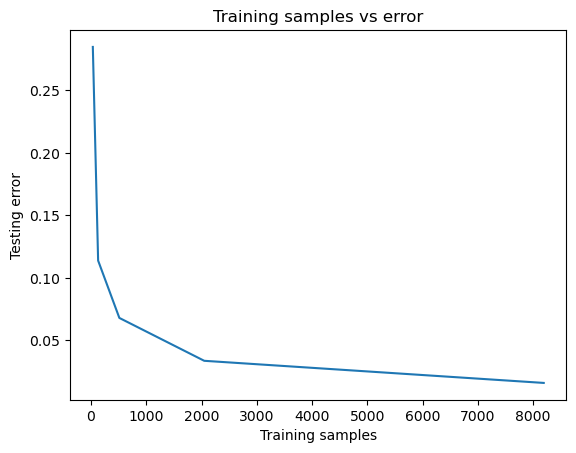

In [18]:
x = [8192, 2048, 512, 128, 32]
y = [0.01603, 0.03373, 0.06803, 0.1139, 0.28484]
plt.plot(x,y)
plt.title('Training samples vs error')
plt.xlabel("Training samples")
plt.ylabel("Testing error")

## Question 3 (Sk Learn)

In [19]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree

Prediction error for 8192 training size:  0.01327433628318584
Number of Nodes for 8192 training size :  245


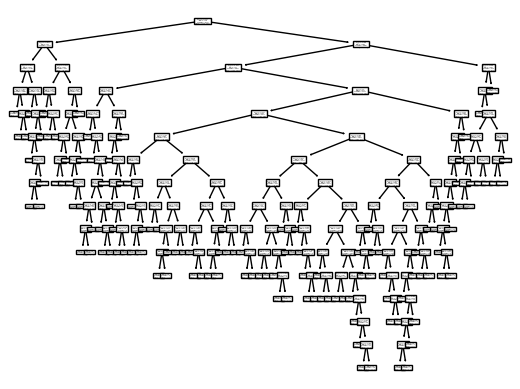

In [20]:
data = train_set

X_test = test_set[:,:-1]
y_test = test_set[:,-1]

X = data[:, :-1]
y = data[:, -1]

clf_8192 = DecisionTreeClassifier()
clf_8192.fit(X, y)

nodes_8192 = clf_8192.tree_.node_count
pred_8192 = clf_8192.predict(X_test)
err_8192 = calculate_error(pred_8192, y_test)
# err_8192 = 1.0 - accuracy_score(y_test, pred_8192)

tree.plot_tree(clf_8192)


print("Prediction error for 8192 training size: ", err_8192)
print("Number of Nodes for 8192 training size : ", nodes_8192)



Prediction error for 2048 training size:  0.020464601769911505
Number of Nodes for 2048 training size :  135


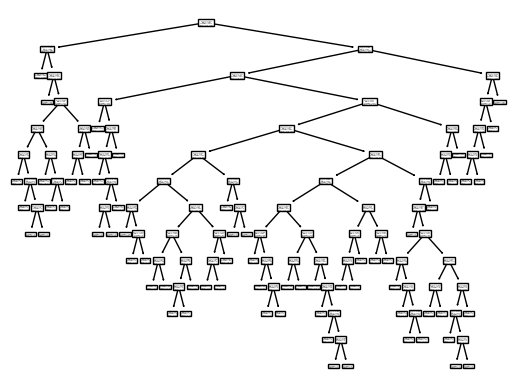

In [21]:
data = D2048
X = data[:, :-1]
y = data[:, -1]

clf_2048 = DecisionTreeClassifier()
clf_2048.fit(X, y)

nodes_2048 = clf_2048.tree_.node_count
pred_2048 = clf_2048.predict(X_test)
err_2048 = calculate_error(pred_2048, y_test)
# err_2048 = 1.0 - accuracy_score(y_test, pred_128)

tree.plot_tree(clf_2048)


print("Prediction error for 2048 training size: ", err_2048)
print("Number of Nodes for 2048 training size : ", nodes_2048)

Prediction error for 512 training size:  0.0586283185840708
Number of Nodes for 512 training size :  61


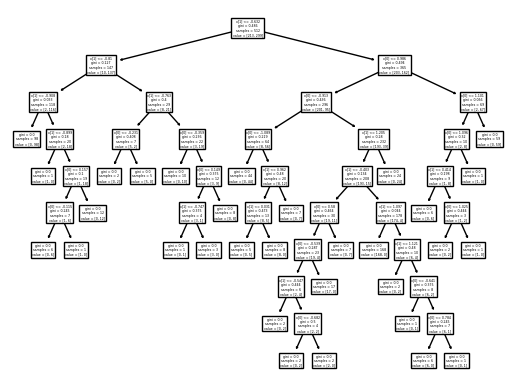

In [22]:
data = D512
X = data[:, :-1]
y = data[:, -1]

clf_512 = DecisionTreeClassifier()
clf_512.fit(X, y)

nodes_512 = clf_512.tree_.node_count
pred_512 = clf_512.predict(X_test)
err_512 = calculate_error(pred_512, y_test)
# err_512 = 1.0 - accuracy_score(y_test, pred_128)
tree.plot_tree(clf_512)


print("Prediction error for 512 training size: ", err_512)
print("Number of Nodes for 512 training size : ", nodes_512)

Prediction error for 128 training size:  0.08185840707964602
Number of Nodes for 128 training size :  21


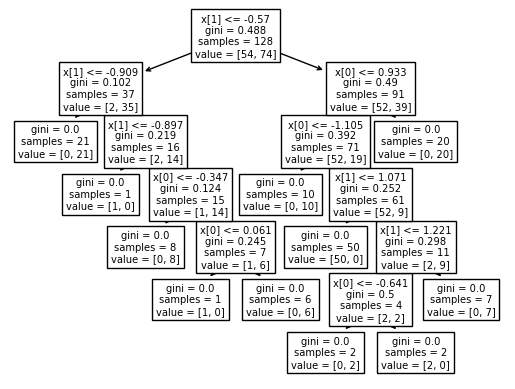

In [23]:
data = D128
X = data[:, :-1]
y = data[:, -1]

clf_128 = DecisionTreeClassifier()
clf_128.fit(X, y)

nodes_128 = clf_128.tree_.node_count
pred_128 = clf_128.predict(X_test)
err_128 = calculate_error(pred_128, y_test)
# err_128 = 1.0 - accuracy_score(y_test, pred_128)

tree.plot_tree(clf_128)


print("Prediction error for 128 training size: ", err_128)
print("Number of Nodes for 128 training size : ", nodes_128)

Prediction error for 32 training size:  0.24778761061946902
Number of Nodes for 32 training size :  11


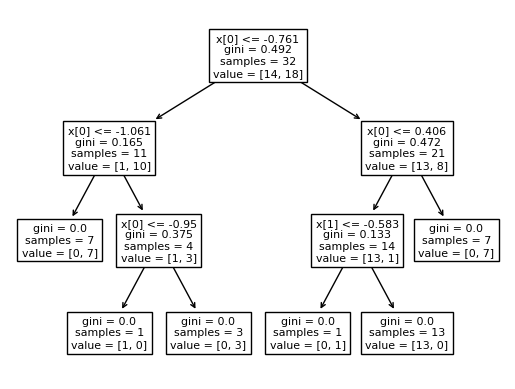

In [24]:
data = D32
X = data[:, :-1]
y = data[:, -1]

clf_32 = DecisionTreeClassifier()
clf_32.fit(X, y)

nodes_32 = clf_32.tree_.node_count
pred_32 = clf_32.predict(X_test)

err_32 = calculate_error(pred_32, y_test)
tree.plot_tree(clf_32)

print("Prediction error for 32 training size: ", err_32)
print("Number of Nodes for 32 training size : ", nodes_32)

Text(0, 0.5, 'Testing error')

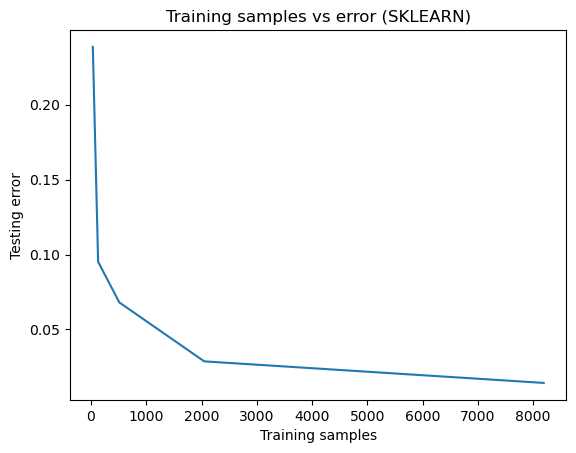

In [25]:
x = [8192, 2048, 512, 128, 32]
y = [0.01438, 0.02876, 0.06803, 0.09513, 0.2384]
plt.plot(x,y)
plt.title('Training samples vs error (SKLEARN)')
plt.xlabel("Training samples")
plt.ylabel("Testing error")

## 4. Langrage interpolation

In [27]:
### No noise

In [44]:
import numpy as np
from scipy.interpolate import lagrange

# Define the interval [a, b]
a = 0
b = 2 * np.pi

# Number of data points
n = 100

# Generate 'n' random values of 'x' uniformly sampled from [a, b]
x_values = np.linspace(a, b, n)

# Calculate 'y' values using the sine function
y_values = np.sin(x_values)

# Build a Lagrange interpolation model 'f'
f = lagrange(x_values, y_values)

# Generate 'n' test points 'x_test' using the same distribution as 'x_values'
x_test_values = np.linspace(a, b, n)

# Calculate the corresponding true 'y_test' values
y_test_values = np.sin(x_test_values)

# Calculate train error
train_error = np.mean((f(x_values) - y_values) ** 2)

# Calculate test error
test_error = np.mean((f(x_test_values) - y_test_values) ** 2)

print("Train Error:", train_error)
print("Test Error:", test_error)


results = []

for epsilon_stddev in [0.0, 0.1, 0.2, 0.3, 0.4]:
    # Add Gaussian noise to 'x' values
    x_noisy_values = x_values + np.random.normal(0, epsilon_stddev, n)

    x_noisy_test = x_test_values + np.random.normal(0, epsilon_stddev, n)

    # Calculate 'y_noisy_values' using the sine function with noisy 'x'
    y_noisy_values = np.sin(x_noisy_values)

    # Build a Lagrange interpolation model 'f_noisy' using noisy data
    f_noisy = lagrange(x_noisy_values, y_noisy_values)

    # Calculate train error with noisy data
    train_error = np.mean((f_noisy(x_noisy_test) - y_values) ** 2)

    # Calculate test error with noisy data
    test_error = np.mean((f_noisy(x_test_values) - y_test_values) ** 2)

    # Store the results
    results.append((epsilon_stddev, train_error, test_error))
for epsilon_stddev, train_error, test_error in results:
    print(f"Standard Deviation of Noise: {epsilon_stddev:.2f}")
    # print(f"Train Error: {train_error}")
    print(f"Test Error: {test_error}")
    print()


Train Error: 2.5792031913588617e+138
Test Error: 2.5792031913588617e+138
Standard Deviation of Noise: 0.00
Test Error: 2.5792031913588617e+138

Standard Deviation of Noise: 0.10
Test Error: 3.100122998314719e+140



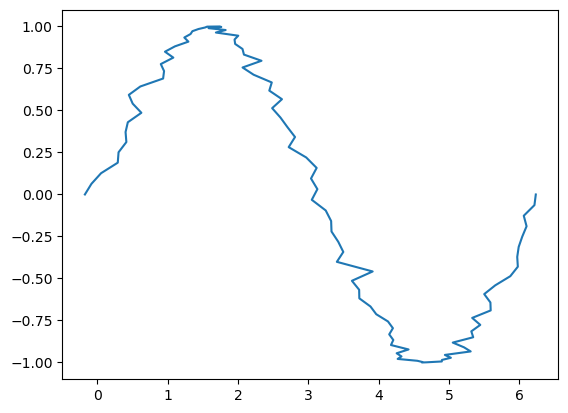

In [45]:
plt.plot(x_noisy_values,y_values)